# Educational Data Mining
----

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from datetime import datetime
from sklearn.ensemble import IsolationForest
pd.set_option('display.max_columns', 40)

In [2]:
STR_FORMAT = '%Y-%m-%d %H:%M:%S'
rng = np.random.RandomState(42)

## Aux

In [3]:

def get_date(ts):
    date = datetime.fromtimestamp(ts).strftime(STR_FORMAT)
    return date


def drop_invalid_columns(df):
    colsdrop = ['Unnamed: 0', 'VAR19', 'VAR29', 'VAR30']
    df = df.drop(colsdrop, axis=1)
    return df


def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_correlations(df, n=5, asc=False, absolute=False):
    au_corr = df.corr().abs().unstack() if absolute else df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=asc)
    return au_corr[0:n]


ranges = {}
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        ranges[feature_name] = (min_value, max_value)
        
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def denormalize(df):
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = df[feature_name] * (ranges[feature_name][1] - ranges[feature_name][0]) + ranges[feature_name][0]
    return result

def get_anomalies(base, reprovados=False, contamination=0.1):
    # Dataset without headers
    sample = base.copy()
    sample.columns = range(sample.shape[1])
    
    #Isolation Forest
    clf = IsolationForest(behaviour='new', max_samples='auto', random_state=rng, 
                          contamination=contamination, n_jobs=-1)
    clf.fit(sample)
    
    # Anomaly Detectin
    scores = clf.decision_function(sample)
    predict  = clf.predict(sample)
    num_outliers = predict.tolist().count(-1)
    
    outliers = []
    outliers_position = []
    while len(outliers) < num_outliers:
        outliers.append(scores.min())
        
        outliers_position.append(scores.argmin()+1)
        scores = np.delete(scores, scores.argmin())
    
    # Found Anomalies    
    anomalias = base.iloc[outliers_position]
    anomalias = anomalias.sort_values(
            by=['DESEMPENHO'],
            ascending=False
            )
    anomalias = anomalias.drop_duplicates()
    
    return anomalias

def anomalias_por_periodo(df_anomalia, title, ax):
    periodos = []
    for _, row in df_anomalia.iterrows():
        periodos.append(row["PERIODO"])

    periodos.sort()
    frequencia = [len(list(group)) for key, group in groupby(periodos)]
    periodos = list(set(periodos))
    
    ax.set_title(title)
    ax.set_xlabel('Período')
    ax.set_ylabel('Frequência')
    ax.set_xticks(np.arange(10))
    ax.bar(periodos, frequencia)

def bar_plot_series(serie, name, save=False):
    plt.figure(figsize=(20,10))
    serie.plot.bar()
    if save:
        plt.savefig('./Outputs/Figuras/'+name+'.svg', bbox_inches='tight')
        return
    plt.show()

def heatmap(df, title, ax):
    df = df.copy()
    df = df.drop("DESEMPENHO_BINARIO", axis=1)
    
    ax.set_title(title)
    corr = df.corr()
    sns.heatmap(
        corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu",
        linewidth=0.5,
        vmin=-1,
        vmax=1,
        ax=ax)
    return corr


## Modeling
----

In [4]:
# Load Data
curso = 'Letras'
base = './Dataset/Subsets/base{}.csv'.format(curso)
df_base = pd.read_csv(base, sep=';', decimal=',', index_col=False)
df_base = drop_invalid_columns(df_base)

In [5]:
# Records by course

df_disciplinas = []
disciplinas = list(df_base["NOME_DA_DISCIPLINA"].drop_duplicates())
for d in disciplinas:
    df_disci = df_base.loc[df_base["NOME_DA_DISCIPLINA"]==d]
    registros = len(df_disci)
    if registros != 0:
        df_disciplinas.append((registros, d))
        
df_disciplinas = pd.DataFrame(df_disciplinas, columns=["registros", "disciplina"])
df_disciplinas = df_disciplinas.sort_values(
        by=["registros"],
        ascending=False
        )
nome_disciplina = df_disciplinas.iat[0, 1]
df_disciplinas.head()

,registros,disciplina
20,434,Morfossintaxe II
18,429,Linguística II
22,418,Psicologia Evolutiva
35,367,Literatura Brasileira I
11,281,Linguística I


In [6]:
# Data Selection

df_base = df_base.sort_values(
        by=['DESEMPENHO'],
        ascending=False
        )

# Course with most records
df_base = df_base.loc[df_base["NOME_DA_DISCIPLINA"]==nome_disciplina]
df_base.head(3)

,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,VAR03,VAR04,VAR05,VAR06,VAR07,VAR08,VAR09,VAR10,VAR12,VAR13,...,PROVA01,PROVA01_2CHAMADA,PRIMEIRA_PROVA,PROVA02,PROVA02_2CHAMADA,SEGUNDA_PROVA,MEDIA_PROVAS,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
5815,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1446,23,0,0,0,45,0,0,0,0,0,0,0,...,4.95,0.0,4.95,5.50,0.0,5.50,5.225,5,5,5,5,2.0,6,5,2.75,9.975,0,5.225,5.0,181 days 23:59:59.000000000
5798,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1513,25,0,0,4,57,0,0,0,0,1,0,15,...,5.50,0.0,5.50,4.95,0.0,4.95,5.225,5,5,5,5,2.0,5,6,2.75,9.975,0,5.225,5.0,181 days 23:59:59.000000000
5736,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1490,2,0,0,18,63,0,2,3,0,0,0,10,...,4.95,0.0,4.95,4.95,0.0,4.95,4.950,5,5,5,5,2.0,6,6,3.00,9.950,0,4.950,5.0,181 days 23:59:59.000000000


In [7]:
print("Registros: Total -> {} | Possíveis Aprovados -> {} | Reprovados -> {}".format(
    len(df_base),
    len(df_base.loc[df_base["DESEMPENHO_BINARIO"] == 0]), 
    len(df_base.loc[df_base["DESEMPENHO_BINARIO"] == 1]))
     )

Registros: Total -> 434 | Possíveis Aprovados -> 214 | Reprovados -> 220


In [8]:
# Select variables of interest
df_clean = df_base[['VAR02', 'VAR03', 'VAR04','VAR06', 'VAR07', 'VAR16','VAR18', 'VAR20',
                   'VAR24', 'VAR31', 'VAR33', 'VAR34', 'PRIMEIRA_PROVA','SEGUNDA_PROVA', 'MEDIA_PROVAS', 
                   'FORUM01', 'FORUM02', 'FORUM03', 'FORUM04','MEDIA_FORUM', 'WEBQUEST01', 'WEBQUEST02', 
                   'MEDIA_WEBQUEST', 'DESEMPENHO', 'DESEMPENHO_BINARIO']]

# Cleanup invalid data
des = df_clean['DESEMPENHO'].copy()
df_clean.loc[:,'DESEMPENHO'] = des.apply(lambda x: 10 if x>=10 else x)
df_clean.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,PRIMEIRA_PROVA,SEGUNDA_PROVA,MEDIA_PROVAS,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
5815,0,0,0,0,0,0,11,0,4.0,117,2,4,4.95,5.50,5.225,5,5,5,5,2.0,6,5,2.75,9.975,0
5798,0,0,4,0,0,0,37,0,6.0,162,2,4,5.50,4.95,5.225,5,5,5,5,2.0,5,6,2.75,9.975,0
5736,0,0,18,0,2,0,73,0,10.0,283,2,8,4.95,4.95,4.950,5,5,5,5,2.0,6,6,3.00,9.950,0
5728,2,0,19,0,0,1,14,0,8.0,212,3,4,4.95,5.50,5.225,5,5,4,5,1.9,6,5,2.75,9.875,0
5701,0,0,28,0,0,0,23,0,5.0,139,3,4,4.95,5.50,5.225,5,5,4,5,1.9,6,5,2.75,9.875,0


## Analysis
----

### - Normalization

In [9]:
df_clean_norm = normalize(df_clean)
df_clean_norm.head(3)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,PRIMEIRA_PROVA,SEGUNDA_PROVA,MEDIA_PROVAS,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
5815,0.0,0.0,0.000000,0.0,0.0,0.0,0.060109,0.0,0.166667,0.186306,0.5,0.114286,0.9,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.833333,0.916667,1.000000,0.0
5798,0.0,0.0,0.006757,0.0,0.0,0.0,0.202186,0.0,0.250000,0.257962,0.5,0.114286,1.0,0.9,1.000000,1.0,1.0,1.0,1.0,1.0,0.833333,1.000000,0.916667,1.000000,0.0
5736,0.0,0.0,0.030405,0.0,0.1,0.0,0.398907,0.0,0.416667,0.450637,0.5,0.228571,0.9,0.9,0.947368,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.997494,0.0


### - Anomaly Detection

In [10]:
anomalias_norm = get_anomalies(df_clean_norm, contamination='auto')
print("Anomalias: Possíveis Aprovados -> {} | Reprovados -> {}".format(
    len(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 0]), 
    len(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 1]))
     )

Anomalias: Possíveis Aprovados -> 30 | Reprovados -> 7


## Visualization
----

In [11]:
# Removing anomalies from subset
idxc = df_clean_norm.index
idxa = anomalias_norm.index
idxs = idxc.difference(idxa)

df_clean_norm = df_clean_norm.loc[idxs]

### - Variables of Interest
---
| Variable        | Description | Category |
| --------------- | ----------- | --------- |
| VAR02           | Number of messages sent by the student to teachers through the environment.  | Search for Help
| VAR03           | Number of messages sent by the student to teacher assistants through the environment. | Search for Help
| VAR04           | Total number of messages sent by the student through the environment.          | Search for Help
| VAR06           | Number of topics created by the student in forums of type "Clear Up Question".      | Search for Help
| VAR07           | Number of posts created by student on forums of type "Clear Up Question".           | Search for Help
| VAR16           | Number of activites delivered by the student after deadline. | Task Completion Strategy
| VAR18           | Total number of views in the forums (pageviews).                      | Task Completion Strategy
| VAR20           | Number of student replies on the main topic. | Self-Assessment
| VAR24           | Average of student's weekly access to the environment. | Time Management
| VAR31           | Number of student's access to the environment.                     | Time Management
| VAR33           | Number of activites delivered by the student before deadline. | Goal Fulfillment
| VAR34           | Total number of posts created by student on forums.                      | Goal Fulfillment
| PRIMEIRA_PROVA  | First exam grade. | Face-to-Face Exams
| SEGUNDA_PROVA   | Second exam grade.  | Face-to-Face Exams
| MEDIA_PROVAS    | Average of exams grades.      | Face-to-Face Exams
| FORUM01         | First forum grade.      | Forums
| FORUM02         | Second forum grade.         | Forums
| FORUM03         | Thirds forum grade.       | Forums
| FORUM04         | Fourth forum grade.          | Forums
| MEDIA_FORUM     | Average of forums grades | Forums
| WEBQUEST01      | First activity grade (webquest). | Activities (WebQuest)
| WEBQUEST02      | Second activity grade (webquest).  | Activities (WebQuest)
| MEDIA_WEBQUEST  | Average of activities grades       | Activities (WebQuest)
| DESEMPENHO      | 0.55\*MEDIA_PROVAS + 0.2\*MEDIA_FORUM + 0.25\*MEDIA_WEBQUEST | Assessment

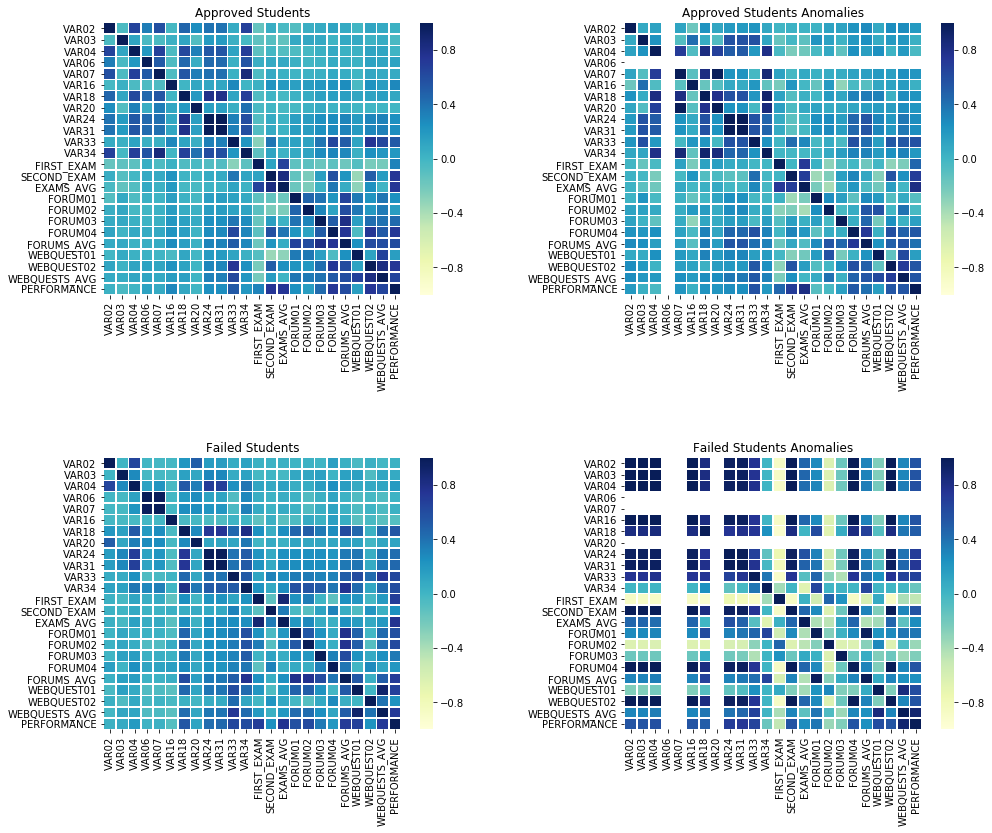

In [12]:
# Heatmap
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,13))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

translation = {
    "PRIMEIRA_PROVA":"FIRST_EXAM", "SEGUNDA_PROVA":"SECOND_EXAM", "MEDIA_PROVAS":"EXAMS_AVG",
    "MEDIA_FORUM":"FORUMS_AVG", "MEDIA_WEBQUEST":"WEBQUESTS_AVG", "DESEMPENHO":"PERFORMANCE"
}
df_clean_norm_t = df_clean_norm.rename(index=str, columns=translation)
anomalias_norm_t = anomalias_norm.rename(index=str, columns=translation)

df_clean_corr = heatmap(df_clean_norm_t.loc[df_clean_norm_t["DESEMPENHO_BINARIO"] == 0], "Approved Students", ax1[0])
anomalias_corr = heatmap(anomalias_norm_t.loc[anomalias_norm_t["DESEMPENHO_BINARIO"] == 0], "Approved Students Anomalies", ax1[1])

_ = heatmap(df_clean_norm_t.loc[df_clean_norm_t["DESEMPENHO_BINARIO"] == 1], "Failed Students", ax2[0])
_ = heatmap(anomalias_norm_t.loc[anomalias_norm_t["DESEMPENHO_BINARIO"] == 1], "Failed Students Anomalies", ax2[1])

## Difference

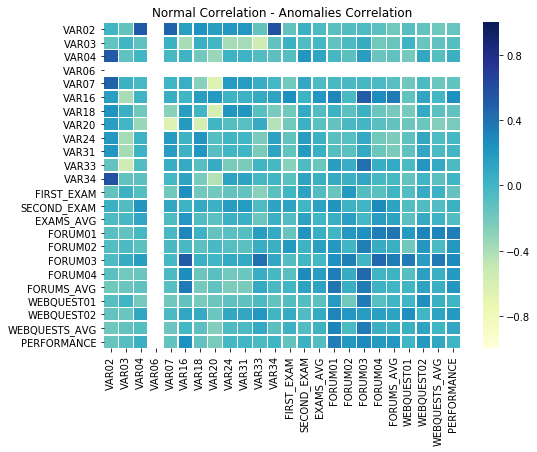

In [13]:
diff = df_clean_corr - anomalias_corr
_, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("Normal Correlation - Anomalies Correlation")
sns.heatmap(
    diff,
    xticklabels=diff.columns,
    yticklabels=diff.columns,
    cmap="YlGnBu",
    linewidth=0.5,
    vmin=-1,
    vmax=1,
    ax=ax)

### Anomaly Analysis

In [14]:
# Denormalization
anomalias_denorm = denormalize(anomalias_norm)

cols = ['VAR02', 'VAR03', 'VAR04','VAR06', 'VAR07', 
        'VAR16','VAR18', 'VAR20','VAR24', 'VAR31', 
        'VAR33', 'VAR34', 'DESEMPENHO']
rows = ["mean","std","min","max"]

anomalias = anomalias_denorm.loc[anomalias_denorm["DESEMPENHO_BINARIO"] == 0].describe()

In [15]:
regular = df_clean.loc[df_clean["DESEMPENHO_BINARIO"] == 0].describe()

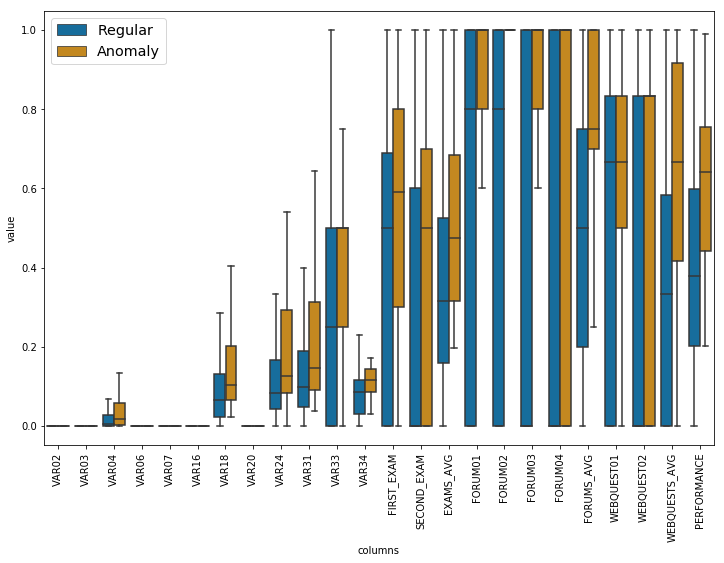

In [16]:
_, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

anomalias_norm["Anomaly"] = True
df_clean_norm["Anomaly"] = False

dfbox = pd.concat([df_clean_norm, anomalias_norm], sort=False)
dfbox = dfbox.rename(index=str, columns=translation)
dfbox = dfbox.drop(["DESEMPENHO_BINARIO"], axis=1)

df_melt = dfbox.melt(id_vars = "Anomaly",
                     var_name = 'columns')

b = sns.boxplot(data = df_melt,
                hue = "Anomaly",
                x = 'columns',
                y = 'value',
                palette="colorblind",
                sym='')

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Regular", "Anomaly"], fontsize='x-large', title_fontsize='16')

In [17]:
diff = regular - anomalias
diff.loc[["mean","std"]]

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,PRIMEIRA_PROVA,SEGUNDA_PROVA,MEDIA_PROVAS,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
mean,-0.054206,-0.578816,-7.583178,0.037383,0.037695,-0.036137,-4.220561,0.032087,-1.393769,-36.422430,-0.276947,-0.558879,0.418283,-0.273551,0.072366,-0.418380,-0.119626,-0.709657,-0.521184,-0.176885,0.009657,-0.880997,-0.217835,-0.322354,0.0
std,-0.034914,-1.594760,7.135228,0.360626,0.560385,-0.038636,-0.469523,0.146631,-1.622404,-40.683344,-0.042478,0.066005,-0.311675,0.169831,0.010240,0.740588,-0.000609,0.574628,0.070853,0.170611,-0.014787,0.390314,0.152900,0.238276,0.0


In [18]:
# Anomalies with complete data

nome_disciplina = nome_disciplina.replace(' ', '')
df_anomalia = df_base.loc[anomalias_denorm.index]
df_anomalia.to_csv('./Dataset/Subsets/Anomalias/anomalias{}Disciplina{}.csv'.format(curso, nome_disciplina), sep=';', decimal=',')
df_anomalia.sort_values(
    by=["DESEMPENHO"], 
    ascending=False
    ).head(10)


,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,VAR03,VAR04,VAR05,VAR06,VAR07,VAR08,VAR09,VAR10,VAR12,VAR13,...,PROVA01,PROVA01_2CHAMADA,PRIMEIRA_PROVA,PROVA02,PROVA02_2CHAMADA,SEGUNDA_PROVA,MEDIA_PROVAS,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
5701,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1497,13,0,0,28,68,0,0,0,0,1,0,9,...,4.95,0.0,4.95,5.50,0.0,5.50,5.225,5,5,4,5,1.9,6,5,2.75,9.875,0,5.225,4.75,181 days 23:59:59.000000000
5865,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1424,10,0,0,4,57,0,0,0,1,1,0,9,...,4.95,0.0,4.95,4.40,0.0,4.40,4.675,4,5,5,5,1.9,5,6,2.75,9.325,0,4.675,4.75,181 days 23:59:59.000000000
5786,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1521,8,3,10,39,82,0,0,0,1,3,0,8,...,5.50,0.0,5.50,3.85,0.0,3.85,4.675,5,5,5,5,2.0,4,6,2.50,9.175,0,4.675,5.00,181 days 23:59:59.000000000
1226,Letras,2011.1,4,Morfossintaxe II,46,2010-12-31 21:00:00,2011-06-29 21:00:00,192,11,1,0,194,347,0,6,11,19,9,0,6,...,4.40,0.0,4.40,2.70,0.0,2.70,3.550,5,5,5,5,2.0,6,6,3.00,8.550,0,3.550,5.00,180 days 00:00:00.000000000
5831,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1470,2,0,0,1,0,0,0,0,1,0,0,16,...,2.48,0.0,2.48,5.50,0.0,5.50,3.990,5,5,5,5,2.0,4,5,2.25,8.240,0,3.990,5.00,181 days 23:59:59.000000000
5837,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1473,4,2,0,9,46,0,0,0,0,1,0,19,...,3.30,0.0,3.30,4.40,0.0,4.40,3.850,4,5,5,5,1.9,4,5,2.25,8.000,0,3.850,4.75,181 days 23:59:59.000000000
5702,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1550,12,0,0,10,70,0,0,0,0,0,0,12,...,3.85,0.0,3.85,2.20,0.0,2.20,3.025,5,5,5,5,2.0,5,6,2.75,7.775,0,3.025,5.00,181 days 23:59:59.000000000
5829,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1532,30,0,0,17,68,0,0,0,0,3,0,7,...,5.50,0.0,5.50,3.85,0.0,3.85,4.675,5,5,5,5,2.0,4,0,1.00,7.675,0,4.675,5.00,181 days 23:59:59.000000000
5761,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1439,5,0,0,2,50,0,0,0,0,0,0,20,...,4.40,0.0,4.40,5.50,0.0,5.50,4.950,4,0,5,0,0.9,3,4,1.75,7.600,0,4.950,2.25,181 days 23:59:59.000000000
5797,Letras,2016.1,4,Morfossintaxe II,50,2015-12-31 21:00:00,2016-06-30 20:59:59,1614,6,0,0,16,67,0,0,0,2,1,0,14,...,2.20,0.0,2.20,3.85,0.0,3.85,3.025,5,5,5,5,2.0,5,5,2.50,7.525,0,3.025,5.00,181 days 23:59:59.000000000
